# Primer GAN

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [10]:
img_rows = 28
img_cols = 28
channels = 1

# Pasarle las dimensiones de la imagen
img_shape = (img_rows, img_cols, channels)

# Tamaño del vector de ruido que se agregara al modelo
z_dim = 100

## Generador

In [3]:
def build_generator(z_dim):

    model = Sequential()

    # Cambio de la dimensiones a una estructura "tensor" de 7x7x256 capas conectadas completamente
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 7x7x256 a un "tensor" de dimension 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # "Batch normalization"
    model.add(BatchNormalization())

    # Activacion de la capa vía Relu
    model.add(LeakyReLU(alpha=0.01))
    
    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 4x14x128 a un "tensor" de dimension 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # "Batch normalization"
    model.add(BatchNormalization())

    # Activacion de la capa vía Relu
    model.add(LeakyReLU(alpha=0.01))

    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 14x14x64 a un "tensor" de dimension 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Activacion de la capa vía tangente hiperbólica
    model.add(Activation('tanh'))

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 28x28x1 a un "tensor" de dimension 14x14x32
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Activacion de la capa vía Relu
    model.add(LeakyReLU(alpha=0.01))

    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 14x14x32 a un "tensor" de dimension 7x7x64
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # "Batch normalization"
    model.add(BatchNormalization())

    # Activacion de la capa vía Relu
    model.add(LeakyReLU(alpha=0.01))

    # Cambiar de las dimensiones de la capa de convolución de un "tensor" de 7x7x64 a un "tensor" de dimension 3x3x128
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # "Batch normalization"
    model.add(BatchNormalization())

    # Activacion de la capa vía Relu
    model.add(LeakyReLU(alpha=0.01))

    # Activacion final vía sigmoide
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Construcción del modelo

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Pasar de un modelo combinado a uno de discriminante
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# instanciar y compilar del discriminante
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# instanciar el generador
generator = build_generator(z_dim)

# Mantener los parametros del discriminador constantes para el entrenamiento del generador
discriminator.trainable = False

# instanciar y compolar el modelo GAN con el disciminante constante para entrenar el generador
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Entrenamiento

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Importar la base de datos de MNIST
    (X_train, _), (_, _) = mnist.load_data()

    # Reescalar los pixeles de la escala de grises [0, 255] al [-1 ,1] 
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Etiquetar como 1 las imagenes reales
    real = np.ones((batch_size, 1))

    # Etiquetar como 0 las imagenes falsas
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # Entrenamiento del discriminador

        # Tomar un conjunto aleatorio de imagenes reales
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generar un conjunto de imagenes falsas
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Entrenar el discriminador
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenamiento del Generador

        # Generar nuevamente un conjunto de imagenes falsas
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Entrenar el generador
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Guardar las perdidas y la precisión para su seguimiento
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Proceso de entrenamiento
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Muestra de imagenes generadas
            sample_images(generator)

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Muestra aleatoria de ruido
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generar imagenes con el ruido aleatorio
    gen_imgs = generator.predict(z)

    # Rescalar imagenes al [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Grid para pintar la imagen
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Imagen
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Entrenamiento del modeo

Notar que el warning `'Discrepancy between trainable weights and collected trainable'` de Keras es de esperarse debido a que, por diseño, los parametros del generador se dejaron constante durante el entremiento del discriminador y lo mismo al reves.

/usr/local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.076426, acc.: 98.44%] [G loss: 5.462180]
2000 [D loss: 0.035508, acc.: 99.61%] [G loss: 4.258853]
3000 [D loss: 0.102996, acc.: 98.05%] [G loss: 4.361682]
4000 [D loss: 0.096209, acc.: 98.44%] [G loss: 4.374659]
5000 [D loss: 0.055545, acc.: 98.44%] [G loss: 4.661900]


KeyboardInterrupt: 

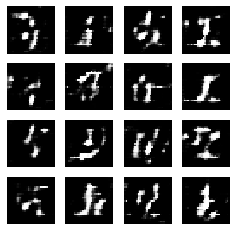

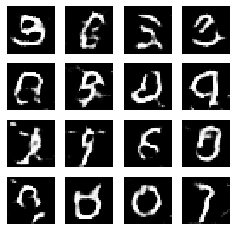

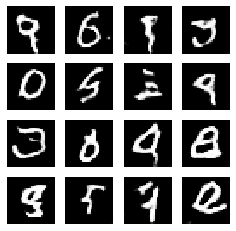

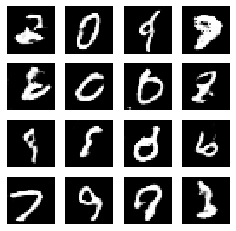

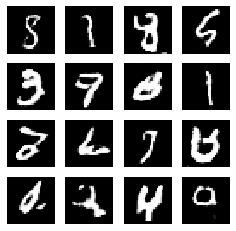

In [9]:
# Hiperparametros
iterations = 20000
batch_size = 128
sample_interval = 1000

# Entrenar el DCGAN para las iteraciones dadas
train(iterations, batch_size, sample_interval)

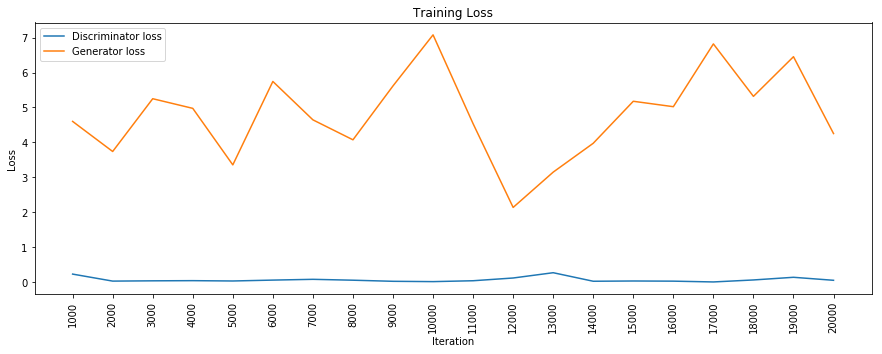

In [10]:
losses = np.array(losses)

# GRaficar las perdidas del entrenamiento para el discriminador y el generador.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

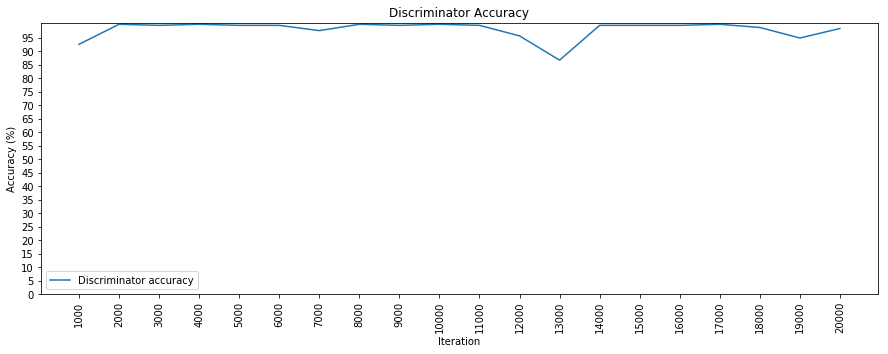

In [11]:
accuracies = np.array(accuracies)

# Grafica de la precisión del discriminante.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

## Cargar el modelo

In [1]:
from keras.models import load_model
gan_entrenada= load_model('gan.h5')

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [27]:
print('Gan')
gan_entrenada.summary()
gen_entrenado = gan_entrenada.get_layer(index=0)
print('Generador')
gen_entrenado.summary()

Gan
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 95489     
Total params: 1,732,610
Trainable params: 1,731,842
Non-trainable params: 768
_________________________________________________________________
Generador
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       295040    
______

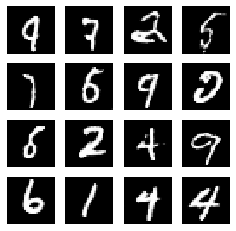

In [29]:
sample_images(gen_entrenado)

In [24]:
# Crear el modelo desde un json
from keras.models import model_from_json
json_file = open('gan.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gan_weights.h5")
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 95489     
Total params: 1,732,610
Trainable params: 1,731,842
Non-trainable params: 768
_________________________________________________________________
